In [1]:
## The imports 
import numpy as np
from PIL import Image 
import cv2
from matplotlib import pyplot as plt

In [2]:
#The Defines
DOLLAR_PATH = 'images/dollar.tif'
Sigma0 = 900
Sigma1 = Sigma0 * np.sqrt(3) / 2
DOWN_SAMPLE_RATE = 2
UP_SAMPLE_RATE = 2
D0 = 40

In [3]:
## Functions

def create_mask(D0, src, mask_type): # This function will be convolving a FILTER_SIZE * FILTER_SIZE filter with the image
    mask = np.zeros_like(src, float)
    if mask_type == "Gaussian":
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                mask[i, j] = (np.exp(-1 * ((i - int(src.shape[0]/2 + 1)) * (i - int(src.shape[0]/2 + 1)) + (j - int(src.shape[1]/2 + 1)) * (j - int(src.shape[1]/2 + 1))) / (2 * D0 * D0)))   
    elif mask_type == "Ideal":
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                mask[i, j] = ((i - int(src.shape[0]/2 + 1)) * (i - int(src.shape[0]/2 + 1)) + (j - int(src.shape[1]/2 + 1)) * (j - int(src.shape[1]/2 + 1))) < (D0 * D0)
    return mask

def upsample(img, up_sample): # This function is for upsamling the image if will use the up_sample factor for it
    new_img = np.zeros((2 * img.shape[0], 2 * img.shape[1]))
    for i in range(img.shape[0]):
        new_img[int(2 * i), range(0, new_img.shape[1], up_sample)] = img[i, range(img.shape[1])]
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if j == img.shape[1] - 1:
                new_img[2*i, 2 * j + 1] = new_img[2*i, 2 * j]
                break
            new_img[2*i, 2 * j + 1] = (new_img[2 * i, 2 * j] + new_img[2 * i, 2 * j + 2]) / 2
    for i in range(img.shape[0] - 1):
        new_img[2*i+1,:] = (new_img[2 * i, :] + new_img[2 * i +2, :]) / 2
    return new_img

In [4]:
# We read the image
Dollar_img = cv2.imread(DOLLAR_PATH, 0)
src = np.copy(Dollar_img)

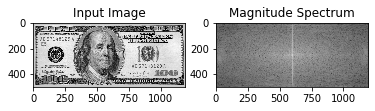

In [9]:
# We calcualte the dft pf the image that we have 
DFT = np.fft.fft2(src)
DFT = np.fft.fftshift(DFT)

# We plot the result that we have
plt.subplot(121),plt.imshow(src, cmap = 'gray')
plt.title('Input Image')
plt.subplot(122),plt.imshow(20 * np.log(np.abs(DFT)), cmap = 'gray')
plt.title('Magnitude Spectrum')
plt.show()

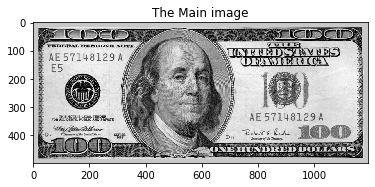

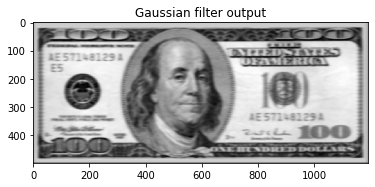

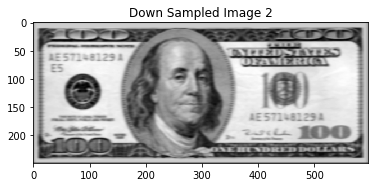

In [6]:
# In this part we apply the gaussian filter that we have eplemented with function
mask = create_mask(D0, DFT, "Gaussian")
New_DFT_C = (mask * DFT)
rows, cols = src.shape

src_after_filter = np.fft.ifftshift(New_DFT_C)
src_after_filter = (np.abs(np.fft.ifft2(src_after_filter))).round()

# We apply that filter to our image
src2 = []
# We will also down sample the image
for i in range(0, src_after_filter.shape[0], DOWN_SAMPLE_RATE):
    src2.append(src_after_filter[i, range(0, src_after_filter.shape[1], DOWN_SAMPLE_RATE)])

# We will plot the new image
Blur1 = src - src_after_filter
src2 = np.array(src2)
plt.imshow(src, cmap = 'gray')
plt.title('The Main image')
plt.show()
plt.imshow((src_after_filter), cmap = 'gray')
plt.title('Gaussian filter output')
plt.show()
plt.imshow(src2, cmap = 'gray')
plt.title('Down Sampled Image 2')
plt.show() 

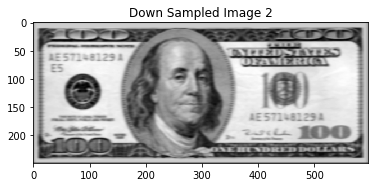

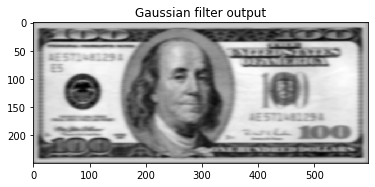

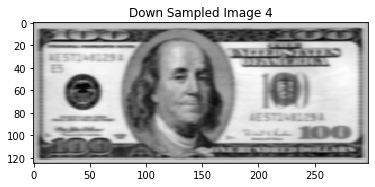

In [7]:
# In this part we apply the gaussian filter that we have eplemented with function
DFT2 = np.fft.fft2(np.float32(src2))
DFT2 = np.fft.fftshift(DFT2)

mask = create_mask(D0, DFT2, "Gaussian")
after_filter = (mask * DFT2)
rows, cols = src2.shape

f_ishift = np.fft.ifftshift(after_filter)
src2_after_filter = np.fft.ifftshift(f_ishift)
src2_after_filter = (np.abs(np.fft.ifft2(src2_after_filter))).round()

# We apply that filter to our image

# We will also down sample the image
src4 = []
for i in range(0, src2_after_filter.shape[0], DOWN_SAMPLE_RATE):
    src4.append(src2_after_filter[i, range(0, src2_after_filter.shape[1], DOWN_SAMPLE_RATE)])

# We will plot the new image
Blur2 = src2 - src2_after_filter
plt.imshow(src2, cmap = 'gray')
plt.title('Down Sampled Image 2')
plt.show()
plt.imshow(src2_after_filter, cmap = 'gray')
plt.title('Gaussian filter output')
plt.show()
plt.imshow(src4, cmap = 'gray')
plt.title('Down Sampled Image 4')
plt.show() 

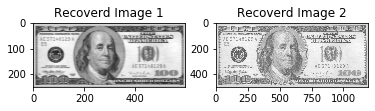

In [10]:
## The recovery
# This part we are going to use the bluer part and recover the image that we have
# we need to up sample the image as well
upsamp1 = upsample(np.array(src4), UP_SAMPLE_RATE)
upsamp1 = upsamp1 + Blur2
plt.subplot(121),plt.imshow(upsamp1,cmap = 'gray')
plt.title('Recoverd Image 1')

# we need to do this again bercause the down sampling has been done twice
upsamp2 = upsample(np.array(upsamp1), UP_SAMPLE_RATE)
upsamp2 = upsamp2 + Blur1
plt.subplot(122),plt.imshow(upsamp2,cmap = 'gray')
plt.title('Recoverd Image 2')
plt.show() 

